## Analyse de la structure de bande électronique d'un matériau

In [ ]:
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifWriter
from IPython.display import FileLink
from pymatgen.electronic_structure.plotter import BSPlotter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mp_key = "fShF0m8lEepeLAjHYRHR50cMgpJGq7yr"
mp_id = "mp-16763"
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
band_struc = m.get_bandstructure_by_material_id(mp_id)    


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## Détermination de la bande interdite

Nous utilisons `bandstructure.get_band_gap()` pour extraire l’énergie de la bande interdite du matériau.
Cette énergie nous permet de classer le matériau comme :

- Métallique : $E_{gap} = 0$ eV
- Semi-conducteur : $0 < E_{gap} < 3$ eV (en général)
- Isolant : $E_{gap} \gg 3$ eV

Une bande interdite $\textit{band gap}$ peut être :

Directe si le minimum de la bande de conduction $\textbf{CBM}$ et le maximum de la bande de valence $\textbf{VBM}$ se situent au même vecteur d'onde $k$.
Indirecte si ces points sont à des $k$ différents, impliquant qu’une transition électronique nécessite un transfert de moment.


Bande interdite (Gap): 1.2981000000000003 eV
La bande interdite est indirect


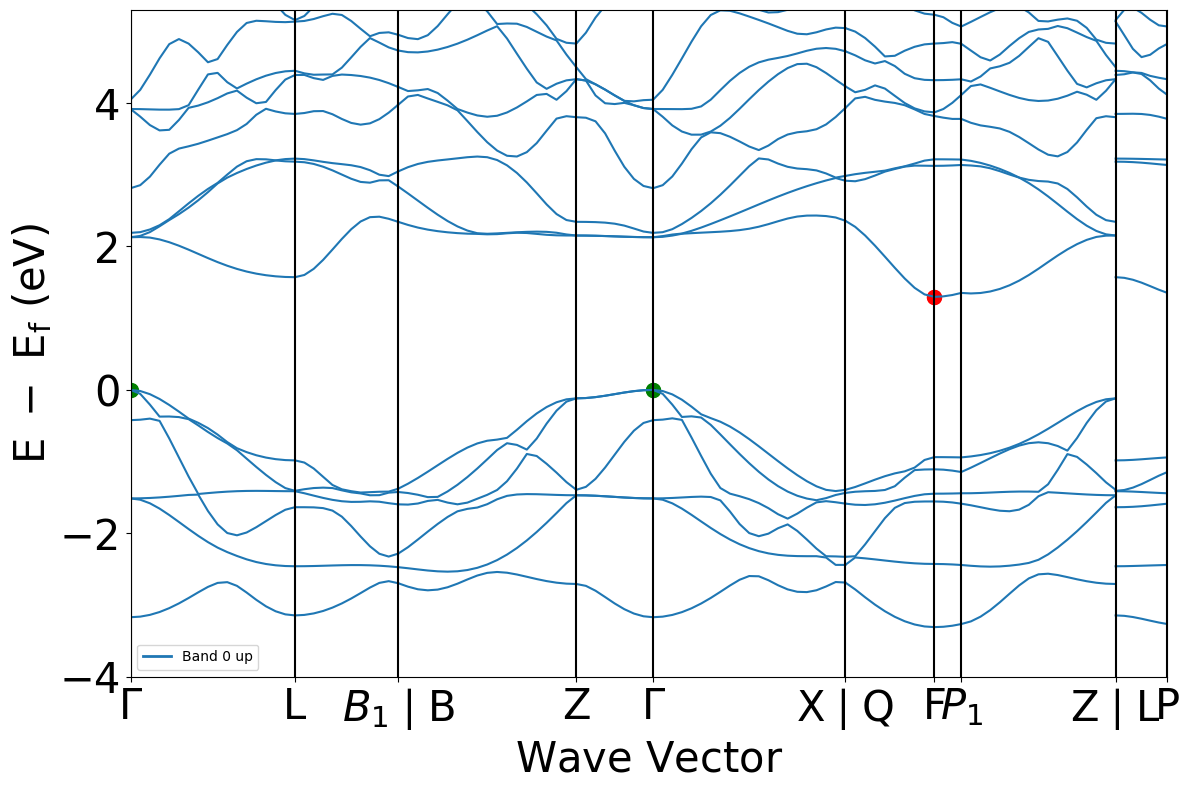

In [3]:
band_gap = band_struc.get_band_gap()
print(f"Bande interdite (Gap): {band_gap['energy']} eV")

if band_gap["direct"] is True:
    print("La bande interdite est direct")
if band_gap["direct"] is False:
    print("La bande interdite est indirect")

# Tracé de la structure de bande
bs_plotter = BSPlotter(band_struc)
bs_plotter.get_plot(vbm_cbm_marker=True)
plt.show()

## Analyse de la dispersion

La dispersion d’une bande est définie par la variation de l’énergie $E(k)$ en fonction du vecteur d’onde $k$.
Une forte dispersion signifie que l’énergie varie rapidement avec $k$. Cela implique une grande mobilité des électrons dans cette direction.
Une faible dispersion signifie que l’énergie varie lentement avec $k$. Cela indique que les électrons se déplacent plus difficilement.

L’analyse de la dispersion nous permet de déterminer :

- Les directions où la bande de valence présente la plus forte et la plus faible dispersion.
- Les directions où la bande de conduction présente la plus forte et la plus faible dispersion.

Nous utilisons la pente $\frac{dE}{dk}$ pour quantifier la dispersion et affichons les résultats avec des flèches sur le graphe de la structure de bande.


Sur la dernière bande de valence, la plus grande dispersion se trouve sur la branche 0, et la plus petite sur 1.
Pour la première bande de conduction, la plus grande dispersion se trouve sur la branche 5, et la plus petite sur 3.


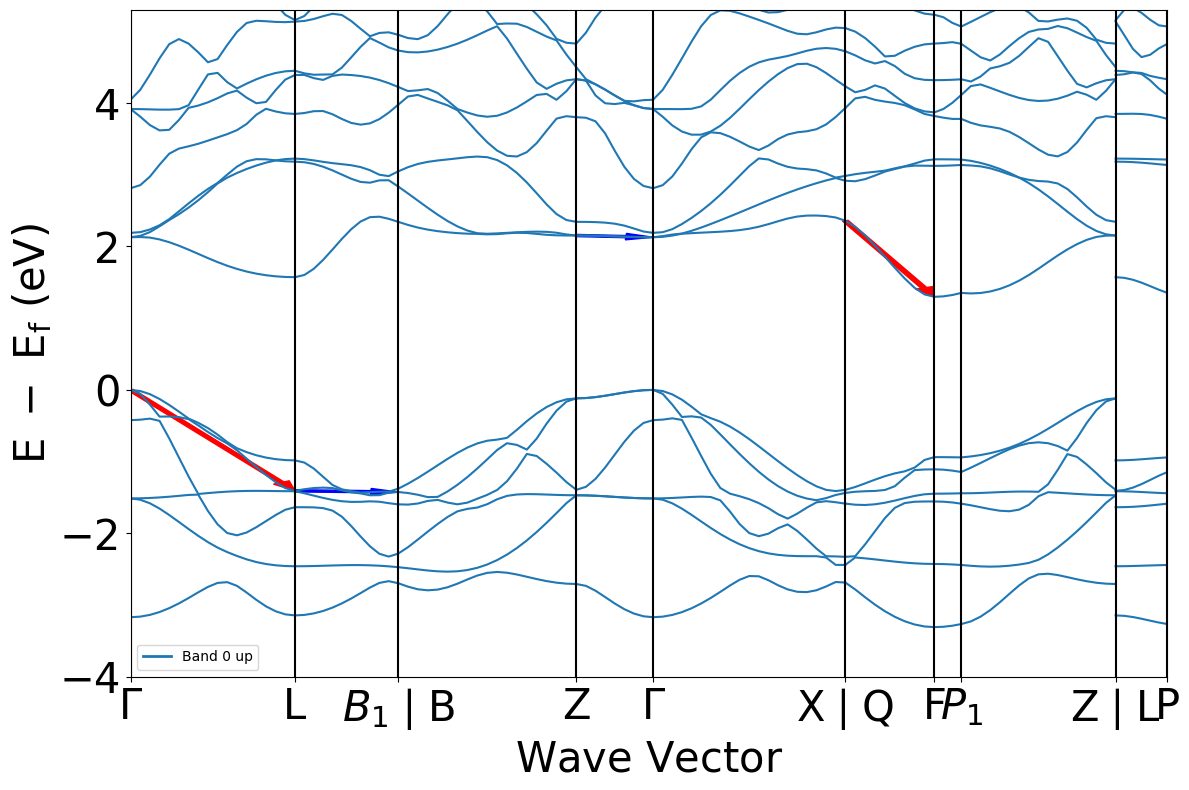

In [4]:
# Récupération des données
data = bs_plotter.bs_plot_data()
distances = data['distances']
energy = data['energy']
vbm_index = list(band_struc.get_vbm()['band_index'].values())[0][0]
cbm_index = list(band_struc.get_cbm()['band_index'].values())[0][0]

# Fonction pour calculer la dispersion
def calculate_dispersion(index, band_type):
    dispersion = []
    for i in range(len(distances)):
        dD = distances[i][0] - distances[i][-1]
        dE = energy['1'][i][index][0] - energy['1'][i][index][-1]
        dispersion.append(abs(dE / dD))
    return dispersion

# Calcul des dispersions pour la bande de valence et de conduction
Valence_disp = calculate_dispersion(vbm_index, "valence")
Conduction_disp = calculate_dispersion(cbm_index, "conduction")

# Indices des dispersions maximales et minimales
Valence_max, Valence_min = np.argmax(Valence_disp), np.argmin(Valence_disp)
Cond_max, Cond_min = np.argmax(Conduction_disp), np.argmin(Conduction_disp)

# Affichage des résultats
print(f"Sur la dernière bande de valence, la plus grande dispersion se trouve sur la branche {Valence_max}, et la plus petite sur {Valence_min}.")
print(f"Pour la première bande de conduction, la plus grande dispersion se trouve sur la branche {Cond_max}, et la plus petite sur {Cond_min}.")

bs_plotter.get_plot(vbm_cbm_marker=False)

# Fonction pour tracer les flèches
def plot_arrow(index, band_index, color):
    plt.arrow(distances[index][0], energy['1'][index][band_index][0], 
              distances[index][-1] - distances[index][0],
              energy['1'][index][band_index][-1] - energy['1'][index][band_index][0],
              width=0.03, length_includes_head=True, color=color)

# Tracer les dispersions maximales et minimales
plot_arrow(Valence_min, vbm_index, 'blue')  # Valence min dispersion
plot_arrow(Valence_max, vbm_index, 'red')   # Valence max dispersion
plot_arrow(Cond_min, cbm_index, 'blue')     # Conduction min dispersion
plot_arrow(Cond_max, cbm_index, 'red')      # Conduction max dispersion

plt.show()


## Calcul de la masse effective

### Définition physique
La **masse effective** $m^*$ est une approximation de la réponse d’un électron dans un matériau sous l’effet d’un champ électrique.  
Elle est définie par :

$$ m^* = \frac{\hbar^2}{\frac{d^2E}{dk^2}}$$

où :
- $\hbar$ est la constante de Planck réduite  
- $\frac{d^2E}{dk^2}$ est la courbure de la relation de dispersion $E(k)$ 


### Approximation numérique
Pour calculer $\frac{d^2E}{dk^2}$, j'utilise l’approximation par **différences finies** :

$$\frac{d^2E}{dk^2} \approx \frac{E(k+1) - 2E(k) + E(k-1)}{(k_{+1} - k_0)^2}$$

où :
- $k_0 $ est le **vecteur d’onde du point de référence** (**VBM** ou **CBM**)
- $ k_{+1} $ et $k_{-1} $ sont les **points voisins**  

Nous appliquons cette approximation aux points **VBM (valence band maximum)** et **CBM (conduction band minimum)** pour estimer les **masses effectives des électrons**.


### Interprétation des résultats
Après le calcul :
- **Une petite masse effective** signifie que l’électron **se déplace facilement** $ \rightarrow $ **bonne conductivité**.
- **Une grande masse effective** signifie que la particule **a du mal à se déplacer** $ \rightarrow $ **faible mobilité**.


In [5]:
h_barre = 1.054571818*10**(-34)
eV = 1.602176563*10**(-19) #[J]
A = 10**(-10) #[m]


k_values = np.array([d[0] for d in distances])  
E_valence = np.array([e[vbm_index][0] for e in energy['1']])  
E_conduction = np.array([e[cbm_index][0] for e in energy['1']])  

# Fonction pour approximer la dérivée seconde et calculer la masse effective
def calculate_effective_mass(E, idx):
    idx_right = min(idx + 1, len(k_values) - 1)
    idx_left = max(idx - 1, 0)
    dE_dk2 = (E[idx_right] - 2 * E[idx] + E[idx_left]) / ((k_values[idx_right] - k_values[idx])**2)
    return h_barre**2 / (dE_dk2 * A**2 * eV)

# Calcul des masses effectives au VBM et CBM
m_eff_VBM = calculate_effective_mass(E_valence, np.argmax(E_valence))  # Sommet valence
m_eff_CBM = calculate_effective_mass(E_conduction, np.argmin(E_conduction))  # Base conduction

# Affichage des résultats
print(f"Masse effective au sommet de la bande de valence (VBM) : {m_eff_VBM:.2e} kg")
print(f"Masse effective à la base de la bande de conduction (CBM) : {m_eff_CBM:.2e} kg")




Masse effective au sommet de la bande de valence (VBM) : -3.28e-30 kg
Masse effective à la base de la bande de conduction (CBM) : 1.10e-31 kg
